In [1]:
from natsort import natsorted
import matplotlib.pyplot as plt
from glob import glob
import json
from functools import partial
import numpy as np
import imageio
from skimage import img_as_float32
import cv2 as cv2
from math import pi, e, sqrt, cos, sin
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import euclidean
from scipy.ndimage import sobel
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans

In [32]:
path_pairs = list(zip(
natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([cv2.resize(img_as_float32(imageio.imread(ipath)), (256, 192)) for ipath, _ in path_pairs])
msks = np.array([cv2.resize(img_as_float32(imageio.imread(mpath)), (256, 192)) for _, mpath in path_pairs])

/tmp/ipykernel_9518/1613280528.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = np.array([cv2.resize(img_as_float32(imageio.imread(ipath)), (256, 192)) for ipath, _ in path_pairs])
/tmp/ipykernel_9518/1613280528.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  msks = np.array([cv2.resize(img_as_float32(imageio.imread(mpath)), (256, 192)) for _, mpath in path_pairs])


In [33]:
def split(images, masks, train_size=0.7, validation_size=0.15, test_size=0.15, seed=42):

    np.random.seed(seed)

    ind = np.arange(len(images))
    np.random.shuffle(ind)

    train = ind[0 :int(len(images)*train_size) + 1]
    val = ind[len(train):len(train) + int(len(images)*validation_size)]
    test = ind[len(train)+len(val):len(train) + len(val) + int(len(images)*test_size)]

    train_imgs = np.array([images[i] for i in train])
    train_masks = np.array([masks[i] for i in train])

    validate_imgs = np.array([images[i] for i in val])
    validate_masks = np.array([masks[i] for i in val])

    test_imgs = np.array([images[i] for i in test])
    test_masks = np.array([masks[i] for i in test])


    return train_imgs, train_masks, validate_imgs, validate_masks, test_imgs, test_masks

def extract_features(image):

    def norm(arr):
        return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

    image = cv2.GaussianBlur(image, (7, 7), 3)

    features = None
    for rgb_channel in cv2.split(image):
        if features is None:
            features = np.array(rgb_channel.flatten().astype(np.float32))
        else:
            features = np.vstack((features, rgb_channel.flatten().astype(np.float32)))

    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    for hsv_channel in cv2.split(image_hsv):
        if features is None:
            features = np.array(hsv_channel.flatten().astype(np.float32))
        else:
            features = np.vstack((features, norm(hsv_channel.flatten().astype(np.float32))))

    return features
    
def apply_mask(features, mask, background=False):

    data = []
    mask = mask.astype(bool).flatten()
    if background:
        mask = np.invert(mask)
    for feature in features:
        masked = feature[mask == True]
        data.append(masked.flatten())
    return np.array(data)

x_train, y_train, x_val, y_val, x_test, y_test = split(imgs, msks, train_size=0.7, validation_size=0.15, test_size=0.15)

train_data = np.array([extract_features(train_image) for train_image in x_train])
x_val = np.array([extract_features(validate_image) for validate_image in x_val])
# x_test = np.array([extract_features(test_image) for test_image in x_test])

train_bg_data = [apply_mask(features, mask, background=True) 
                for features, mask in zip(train_data, y_train)]
train_fg_data = [apply_mask(features, mask, background=False) 
                for features, mask in zip(train_data, y_train)]

train_bg_data = np.concatenate(train_bg_data, axis=1)
train_fg_data = np.concatenate(train_fg_data, axis=1)

In [34]:
class params():
    def __init__(self, lmda, cov, mu):
        self.lmda = lmda
        self.cov = cov
        self.mu = mu

    def diff(self, other):
        return np.abs(self.lmda - other.lmda) + euclidean(self.mu, other.mu) + euclidean(self.cov.flatten(), other.cov.flatten())

class GMM():
    def init_params(self, x):
        n = x.shape[1]
        
        # Initial uniform disctribution
        lmbda = 1 / self.k
        # Initial means
        if self.kmeans:
            if self.kmeans_centers is None:
                print('Finding K-means Centers')
                self.kmeans_centers = np.squeeze(KMeans(n).fit(x.T.flatten().reshape(-1, 1)).cluster_centers_.reshape((1, n)))
            mu = self.kmeans_centers
        else:
            mu = np.random.choice(x.flatten(), n)
        # Iniital covariance
        cov = np.random.random((n, n))
        cov *= cov.T
        cov += n * np.eye(n)
        return params(lmbda, cov, mu)

    def __init__(self, k, tol=1e-4, min_iter=5, max_iter=100, seed=42, kmeans=True):
        self.k = k
        self.tol = tol
        self.min_iter = min_iter
        self.max_iter = max_iter
        self.seed = seed
        self.kmeans = kmeans
        self.kmeans_centers = None
        self.params = None

    def e_step(self, x, param):
        n_samples = x.shape[0]
        responsibilities = np.zeros((n_samples, self.k))
        weighted_gaussians = np.zeros((n_samples, self.k))
        # Get normal distributions using current parameter set
        for i in range(self.k):
            weighted_gaussians[:, i] = param[i].lmda * \
                                       multivariate_normal.pdf(x, param[i].mu, param[i].cov)
        # Compute responsibility for each cluster
        for i in range(self.k):
            responsibilities[:, i] = weighted_gaussians[:, i] / np.sum(weighted_gaussians, axis=1, initial=1e-10)
        return responsibilities

    def m_step(self, x, res):
        gaussian_parameters = []
        for i in range(self.k):
            k_sum_responsibility = np.sum(res[:, i])
            lmbda = k_sum_responsibility / (np.sum(np.sum(res, axis=1)))
            mu = np.dot(res[:, i], x) / k_sum_responsibility
            standardised_x = x - mu
            cov = np.dot((standardised_x.T * res[:, i]), standardised_x) / k_sum_responsibility
            # Add small value to diagonal to prevent singular matrix
            cov += np.eye(len(cov)) * 1e-10
            gaussian_parameters.append(params(lmbda, cov, mu))
        return gaussian_parameters

    def fit(self, X):
        done = False

        i = 0
        param = [self.init_params(X) for _k in range(self.k)]
        while not done and i < self.max_iter:
            res = self.e_step(X, param)
            param_new = self.m_step(X, res)

            change_total = 0

            for _k, p in enumerate(param_new):
                change_total += p.diff(param[_k])

            done = change_total < self.tol and i >= self.min_iter

            print(f'Iter {i} : Change {change_total}')

            i += 1
            param = param_new

        self.params = param

    def predict(self, X):
        n = X.shape[0]
        g_pdfs = np.zeros((X.shape[0], X.shape[1], self.k))

        for i in range(self.k):
            g_pdfs[:,:, i] = self.params[i].lmda * multivariate_normal(self.params[i].mu, self.params[i].cov).pdf(X)
        return np.sum(g_pdfs, axis=2)

In [35]:
bg = GMM(5, kmeans=True, tol=1e-3, min_iter=0, max_iter=50)
bg.fit(train_bg_data.T)

Finding K-means Centers
Iter 0 : Change 81.41780760310027
Iter 1 : Change 0.038185207368400934
Iter 2 : Change 0.005850184704154975
Iter 3 : Change 0.015153188477708102
Iter 4 : Change 0.08019974427110577
Iter 5 : Change 0.21449699540704226
Iter 6 : Change 0.2205418799304941
Iter 7 : Change 0.23157988849627464
Iter 8 : Change 0.20502053578743037
Iter 9 : Change 0.21796497868349896
Iter 10 : Change 0.18979775695937798
Iter 11 : Change 0.12298883344146441
Iter 12 : Change 0.08217867679702605
Iter 13 : Change 0.06308667877476654
Iter 14 : Change 0.051885274875422736
Iter 15 : Change 0.04537216592977831
Iter 16 : Change 0.04278262436446022
Iter 17 : Change 0.04279708350335903
Iter 18 : Change 0.04249147012784016
Iter 19 : Change 0.041061659156763235
Iter 20 : Change 0.03982765605594219
Iter 21 : Change 0.03397989957026996
Iter 22 : Change 0.02524281061700245
Iter 23 : Change 0.02127970724935755
Iter 24 : Change 0.02063053812369218
Iter 25 : Change 0.018174014750640483
Iter 26 : Change 0.01

In [36]:
fg = GMM(5, kmeans=True, tol=1e-3, min_iter=0, max_iter=50)
fg.fit(train_fg_data.T)

Finding K-means Centers
Iter 0 : Change 79.56002111938746
Iter 1 : Change 0.009941333294778488
Iter 2 : Change 0.027870216564074346
Iter 3 : Change 0.18035159294595424
Iter 4 : Change 0.5173837029257491
Iter 5 : Change 0.7396027112932415
Iter 6 : Change 0.6882220047141869
Iter 7 : Change 0.6198030164484474
Iter 8 : Change 0.5295727472822915
Iter 9 : Change 0.25889535273560316
Iter 10 : Change 0.12671787247843888
Iter 11 : Change 0.07429185745872448
Iter 12 : Change 0.048165233789396564
Iter 13 : Change 0.036471961637940656
Iter 14 : Change 0.031112756531920423
Iter 15 : Change 0.028139861470700224
Iter 16 : Change 0.026959678474257936
Iter 17 : Change 0.026826659724362566
Iter 18 : Change 0.02760124472413617
Iter 19 : Change 0.02893349133809872
Iter 20 : Change 0.030439347880872627
Iter 21 : Change 0.031802526670541745
Iter 22 : Change 0.03297714639538995
Iter 23 : Change 0.03455520581674146
Iter 24 : Change 0.037746917057357415
Iter 25 : Change 0.0480470768074875
Iter 26 : Change 0.08

Prediction #1, accuracy:98.1%


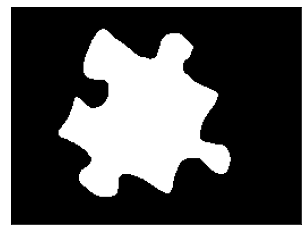

Prediction #2, accuracy:98.76%


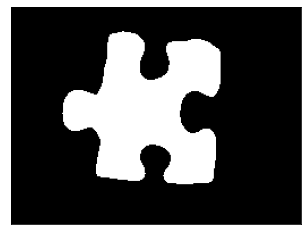

Prediction #3, accuracy:98.36%


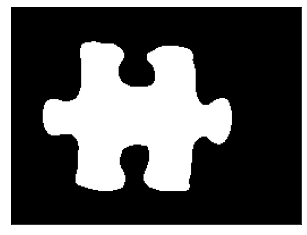

Prediction #4, accuracy:94.02%


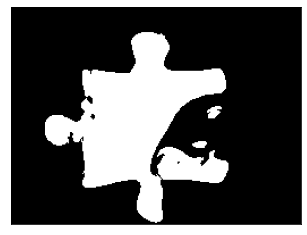

Prediction #5, accuracy:99.06%


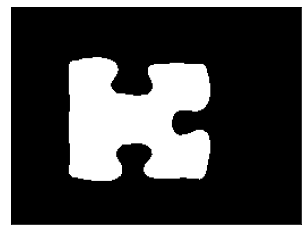

Prediction #6, accuracy:98.26%


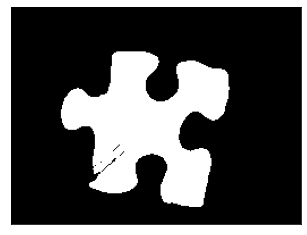

Prediction #7, accuracy:98.22%


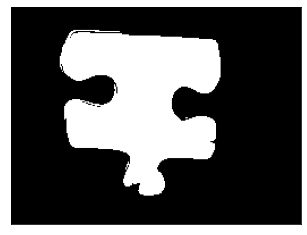

Average accuracy:97.83%


In [37]:
def show_image(image,cs=False,cmap= None, title=None):
    plt.title(title)
    plt.imshow(image.reshape((192, 256)), cmap= cmap)
    plt.xticks([])
    plt.yticks([])

def predict(gmm, X):
    
    n = X.shape[0]
    g_pdfs = np.zeros((X.shape[0], gmm.k))

    for i in range(gmm.k):
        g_pdfs[:, i] = gmm.params[i].lmda * multivariate_normal(gmm.params[i].mu, gmm.params[i].cov).pdf(X)
    return np.sum(g_pdfs, axis=1)

def predict_foreground(X, bg_gmm, fg_gmm, lmbda):

    fg_dist = predict(fg_gmm, X)
    bg_dist = predict(bg_gmm, X)
    y = (lmbda * fg_dist) / ((lmbda * fg_dist) + ((1 - lmbda) * bg_dist))
    return (y >= 0.5).astype(np.float32)


def validate_predictions(validation_data, validation_masks, bg_gmm, fg_gmm, lmbda, plot=True):
    """Predictions on validation set, and average results"""
    predict_count = 0
    total_score = 0
    for data, mask in zip(validation_data, validation_masks):
        predict_count += 1
        y = predict_foreground(data.T, bg_gmm, fg_gmm, lmbda=lmbda)
        score = accuracy_score(y.flatten() + 1, mask.flatten().round() + 1)
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(y, cmap='gray')
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )

def get_lmda(masks):
    f = 0
    t = 0
    for m in masks:
        f += np.sum(m)
        t += np.prod(m.shape)

    return f/t

lmda = get_lmda(y_val)
validate_predictions(x_val, y_val, bg, fg, lmbda=lmda)

In [38]:
x_val.shape

(7, 6, 49152)

Just RGB: 98.34%

RGB+HSV: 98.39%

RGB+HSV Blurred: 98.4%

RGB+HSV Blurred 7x7: 98.55%

RGB+HSV Blurred 7x7, sigma=3: 97.83%


Blurred RGB (3,3): 98.13%

Blurred RGB (7,7): 98.05%